# Определение перспективного тарифа для телеком компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Изучение данных из файла

В первую очередь выведем общую информацию об имеющихся данных, чтобы выделить шаги для этапа предобработки данных. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy import stats as st
import seaborn as sns

calls = pd.read_csv('/datasets/calls.csv')
#calls.head(5)
internet = pd.read_csv('/datasets/internet.csv')
#internet.head(5)
messages = pd.read_csv('/datasets/messages.csv')
#messages.head(5)
tariffs = pd.read_csv('/datasets/tariffs.csv')
#tariffs.head(5)
users = pd.read_csv('/datasets/users.csv')
#users.head(5)

for data in [calls, internet, messages, tariffs, users]: print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None
<class 'pandas.core.frame.D

In [2]:
users.isna().sum().sort_values(ascending = False)

churn_date    462
tariff          0
reg_date        0
last_name       0
first_name      0
city            0
age             0
user_id         0
dtype: int64

### Вывод

По результатам полученной общей информации о данных можно отметить следующие недостатки данных, которые будут устранены на этапе предобработки:
1. во-первых, call_date, session_date, churn_date, reg_date распознаются как текстовые пременные, в то время как они должна иметь формат даты;
2. во-вторых, мы располагаем данными о 500 клиентах, соответственно, при объединении таблиц у нас будут появляться пропуски;
3. в-третьих, в таблице internet есть столбец unnamed, который необходимо удалить;
4. в-четвертых, можно увидеть пропущенные значения в столбце churn_date, которые необходимо заполнить.

## Предобработка данных

В первую очередь удалим незначимый для нас столбец 'Unnamed: 0' в таблице Internet.

In [3]:
internet.drop(['Unnamed: 0'], axis = 1) 

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


Затем заменим текстовый тип столбцов call_date, session_date, churn_date, reg_date на тип даты для удобства работы и проверим успешность замены.

In [4]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
messages['message_date']

0        2018-06-27
1        2018-10-08
2        2018-08-04
3        2018-06-16
4        2018-12-05
            ...    
123031   2018-12-12
123032   2018-09-28
123033   2018-09-27
123034   2018-11-15
123035   2018-11-16
Name: message_date, Length: 123036, dtype: datetime64[ns]

Следующий шаг - работа с пропущенными значениями. В первую очередь обработаем пропущенные значения в столбце churn_date, содержащем информацию о дате прекращения пользования тарифом. Если значение пропущено, то тариф ещё действовал на момент выгрузки данных, соответственно, имеет смысл заполнить пропущенные значения 0.

In [5]:
#users['churn_date'].value_counts()
print('Количество пропусков в колонке "churn_date" до заполнения:', users['churn_date'].isna().sum())
users['churn_date'] = users['churn_date'].fillna(0)
print('Количество пропусков в колонке "churn_date" после заполнения:', users['churn_date'].isna().sum())

Количество пропусков в колонке "churn_date" до заполнения: 462
Количество пропусков в колонке "churn_date" после заполнения: 0


### Вывод

Таким образом, на этапе предобаботки данных были осуществлены две манипуляции с данными: во-первых, все колонки, содержащие информацию о дате, были преведены в формату datetime, во-вторых, пропущенные значения, обнаруженные в колонке, содержащей информацию о дате прекращения пользования тарифом, были заполнены нулем исходя из соображений логики (если дата не указана, скорее всего, отказа не было).

Несмотря на то, что в колонках mb_used и duration было обнаружено большое количество нулевых значений, эти значения нами обрабатываться не будут, так как они "естественны". Так, звонки с нулевой продолжительностью означают, что звонок не был отвечен либо сброшен. Нулевой скачанный трафик может быть связан с пребыванием пользователя вне зоны действия сети либо сознательным отказом пользователя от интернета. 

## Сбор и анализ необходимой информации

В первую очередь необходимо округлить в большую сторону длительность звонков и количество использованных мегабайтов, поскольку условия тарифа таковы, что даже если звонок "длился всего 1 секунду,он будет засчитан как 1 минута" (аналогичный принцип используется для объема интернета).

In [6]:
calls['duration'] = calls['duration'].apply(np.ceil)

Прежде всего, посчитаем для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам; количество отправленных сообщений по месяцам и объем израсходованного интернет-трафика по месяцам.

In [7]:
calls['month'] = calls['call_date'].dt.month
data_calls = calls.pivot_table(index=['user_id','month'],values='duration', aggfunc=['sum', 'count']).reset_index()
data_calls.columns = ['user_id','month','minutes', 'calls']
data_calls

,user_id,month,minutes,calls
0,1000,5,159.0,22
1,1000,6,172.0,43
2,1000,7,340.0,47
3,1000,8,408.0,52
4,1000,9,466.0,58
...,...,...,...,...
3169,1498,10,247.0,41
3170,1499,9,70.0,9
3171,1499,10,449.0,68
3172,1499,11,612.0,74


In [8]:
messages['month'] = messages['message_date'].dt.month
data_messages = messages.pivot_table(index=['user_id','month'],values='message_date', aggfunc=['count']).reset_index()
data_messages.columns = ['user_id','month','messages']
data_messages

,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


In [9]:
data_messages_calls=data_messages.merge(data_calls,on=['user_id','month'], how = 'outer')
data_messages_calls

,user_id,month,messages,minutes,calls
0,1000,5,22.0,159.0,22.0
1,1000,6,60.0,172.0,43.0
2,1000,7,75.0,340.0,47.0
3,1000,8,81.0,408.0,52.0
4,1000,9,57.0,466.0,58.0
...,...,...,...,...,...
3208,1494,8,NaN,262.0,32.0
3209,1494,9,NaN,501.0,66.0
3210,1494,10,NaN,354.0,52.0
3211,1494,11,NaN,411.0,63.0


In [10]:
internet['month'] = internet['session_date'].dt.month
data_internet = internet.pivot_table(index=['user_id','month'],values='mb_used', aggfunc=['sum']).reset_index()
data_internet.columns = ['user_id','month','mb_used']

In [11]:
final_data=data_messages_calls.merge(data_internet,on=['user_id','month'], how = 'outer')
final_data

,user_id,month,messages,minutes,calls,mb_used
0,1000,5,22.0,159.0,22.0,2253.49
1,1000,6,60.0,172.0,43.0,23233.77
2,1000,7,75.0,340.0,47.0,14003.64
3,1000,8,81.0,408.0,52.0,14055.93
4,1000,9,57.0,466.0,58.0,14568.91
...,...,...,...,...,...,...
3209,1494,9,NaN,501.0,66.0,16962.51
3210,1494,10,NaN,354.0,52.0,17767.24
3211,1494,11,NaN,411.0,63.0,18052.45
3212,1494,12,NaN,418.0,62.0,17621.21


In [12]:
final_data = final_data.merge(users[['user_id','tariff','city']], on = ['user_id'])
final_data

,user_id,month,messages,minutes,calls,mb_used,tariff,city
0,1000,5,22.0,159.0,22.0,2253.49,ultra,Краснодар
1,1000,6,60.0,172.0,43.0,23233.77,ultra,Краснодар
2,1000,7,75.0,340.0,47.0,14003.64,ultra,Краснодар
3,1000,8,81.0,408.0,52.0,14055.93,ultra,Краснодар
4,1000,9,57.0,466.0,58.0,14568.91,ultra,Краснодар
...,...,...,...,...,...,...,...,...
3209,1494,8,NaN,262.0,32.0,6590.75,smart,Омск
3210,1494,9,NaN,501.0,66.0,16962.51,smart,Омск
3211,1494,10,NaN,354.0,52.0,17767.24,smart,Омск
3212,1494,11,NaN,411.0,63.0,18052.45,smart,Омск


Для дальнейшей работы составим сводную таблицу, содержащую информацию по всем абонентам.

In [13]:
final_data.isna().sum()

user_id       0
month         0
messages    497
minutes      40
calls        40
mb_used      11
tariff        0
city          0
dtype: int64

Как можно увидеть из общей информации о финальной таблице, таблица содержит пропущенные значения, которые имеет смысл заменить на 0.

In [14]:
final_data=final_data.fillna(0)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 8 columns):
user_id     3214 non-null int64
month       3214 non-null int64
messages    3214 non-null float64
minutes     3214 non-null float64
calls       3214 non-null float64
mb_used     3214 non-null float64
tariff      3214 non-null object
city        3214 non-null object
dtypes: float64(4), int64(2), object(2)
memory usage: 226.0+ KB


Следующим шагом рассчитаем помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

In [15]:
final_data = final_data.merge(tariffs, left_on =['tariff'], right_on = ['tariff_name'])

In [16]:
del final_data['tariff_name']

In [17]:
final_data

,user_id,month,messages,minutes,calls,mb_used,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22.0,159.0,22.0,2253.49,ultra,Краснодар,1000,30720,3000,1950,150,1,1
1,1000,6,60.0,172.0,43.0,23233.77,ultra,Краснодар,1000,30720,3000,1950,150,1,1
2,1000,7,75.0,340.0,47.0,14003.64,ultra,Краснодар,1000,30720,3000,1950,150,1,1
3,1000,8,81.0,408.0,52.0,14055.93,ultra,Краснодар,1000,30720,3000,1950,150,1,1
4,1000,9,57.0,466.0,58.0,14568.91,ultra,Краснодар,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1494,8,0.0,262.0,32.0,6590.75,smart,Омск,50,15360,500,550,200,3,3
3210,1494,9,0.0,501.0,66.0,16962.51,smart,Омск,50,15360,500,550,200,3,3
3211,1494,10,0.0,354.0,52.0,17767.24,smart,Омск,50,15360,500,550,200,3,3
3212,1494,11,0.0,411.0,63.0,18052.45,smart,Омск,50,15360,500,550,200,3,3


In [18]:
final_data['minutes_over'] = (final_data['minutes'] - final_data['minutes_included']) 
final_data.loc[(final_data['minutes_over'] < 0), 'minutes_over'] = 0
final_data['messages_over'] = (final_data['messages'] - final_data['messages_included']) 
final_data.loc[(final_data['messages_over'] < 0), 'messages_over'] = 0
final_data['mb_over'] = (final_data['mb_used'] - final_data['mb_per_month_included'])
final_data.loc[(final_data['mb_over'] < 0), 'mb_over'] = 0

In [19]:
final_data['mb_over'] = final_data['mb_over']/ 1024
final_data['mb_over'] = final_data['mb_over'].apply(np.ceil)
final_data.rename(columns = {'mb_over' : 'gb_over'}, inplace = True)

In [20]:
final_data['revenue'] = (final_data['minutes_over'] * final_data['rub_per_minute']) + (final_data['messages_over'] *  final_data['rub_per_message']) + (final_data['gb_over']*  final_data['rub_per_gb']) + final_data['rub_monthly_fee']

del final_data['minutes_over']
del final_data['messages_over']
del final_data['gb_over']

final_data

,user_id,month,messages,minutes,calls,mb_used,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
0,1000,5,22.0,159.0,22.0,2253.49,ultra,Краснодар,1000,30720,3000,1950,150,1,1,1950.0
1,1000,6,60.0,172.0,43.0,23233.77,ultra,Краснодар,1000,30720,3000,1950,150,1,1,1950.0
2,1000,7,75.0,340.0,47.0,14003.64,ultra,Краснодар,1000,30720,3000,1950,150,1,1,1950.0
3,1000,8,81.0,408.0,52.0,14055.93,ultra,Краснодар,1000,30720,3000,1950,150,1,1,1950.0
4,1000,9,57.0,466.0,58.0,14568.91,ultra,Краснодар,1000,30720,3000,1950,150,1,1,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1494,8,0.0,262.0,32.0,6590.75,smart,Омск,50,15360,500,550,200,3,3,550.0
3210,1494,9,0.0,501.0,66.0,16962.51,smart,Омск,50,15360,500,550,200,3,3,953.0
3211,1494,10,0.0,354.0,52.0,17767.24,smart,Омск,50,15360,500,550,200,3,3,1150.0
3212,1494,11,0.0,411.0,63.0,18052.45,smart,Омск,50,15360,500,550,200,3,3,1150.0


Как можно увидеть из приведенной информации, наиболее прибылен для нас тариф ultra, так как по нему мы получаем выручку больше(что неудивительно, ведь абонентская плата также больше).

In [21]:
final_data.groupby('tariff')['revenue'].mean()

tariff
smart    1289.973531
ultra    2070.152284
Name: revenue, dtype: float64

Как можно увидеть из таблиц, пользователи тарифа "Смарт" не выходят, согласно среднему, из лимита сообщений и минут (у них даже остается небольшая часть тарифа), в тв время как трафика им зачастую не хватает. В свою очередь пользователи "Ультра" в среднем не расходуют и половины трафика, сообщений и звонков, а если превышают, то не намного, что говорит о некотором неудобстве тарифа.

In [22]:
final_data.query('tariff=="smart"').describe().round(2)

,user_id,month,messages,minutes,calls,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
count,2229.00,2229.00,2229.00,2229.00,2229.00,2229.00,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.00
mean,1246.51,8.35,33.38,417.93,58.46,16208.39,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,1289.97
std,146.12,2.92,28.23,190.31,25.94,5870.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,818.40
min,1001.00,1.00,0.00,0.00,0.00,0.00,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,550.00
25%,1121.00,6.00,10.00,282.00,40.00,12643.01,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,550.00
50%,1239.00,9.00,28.00,422.00,60.00,16506.84,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,1023.00
75%,1376.00,11.00,51.00,545.00,76.00,20042.93,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,1750.00
max,1499.00,12.00,143.00,1435.00,198.00,38552.45,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,6770.00


In [23]:
final_data.query('tariff=="ultra"').describe().round(2)

,user_id,month,messages,minutes,calls,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
count,985.00,985.00,985.00,985.00,985.00,985.00,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.00
mean,1263.09,8.25,49.36,526.62,73.39,19468.81,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,2070.15
std,140.69,2.87,47.80,317.61,43.92,10087.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,376.19
min,1000.00,1.00,0.00,0.00,0.00,0.00,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,1950.00
25%,1143.00,6.00,6.00,284.00,41.00,11770.26,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,1950.00
50%,1277.00,9.00,38.00,518.00,74.00,19308.01,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,1950.00
75%,1381.00,11.00,79.00,752.00,104.00,26837.69,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,1950.00
max,1495.00,12.00,224.00,1673.00,244.00,49745.69,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,4800.00


Как можно увидеть из графиков, по объему использованных минут, сообщений и тарифка лидируют пользователи "Смарт", их активность растет от месяца к месяцу (возможно, неиспользованные остатки переносятся на следующий месяц) и к концу года достигают мксимума. Рост в использовании тарифных "благ" пльзователей "Ультра" тоже имеет место, хотя, безусловно, он гораздо менее стремителен.

In [24]:
tariff_ultra= final_data.query('tariff=="ultra"').pivot_table(index=['month'],values=['minutes','messages','mb_used'], aggfunc=['sum'])
tariff_smart= final_data.query('tariff=="smart"').pivot_table(index=['month'],values=['minutes','messages','mb_used'], aggfunc=['sum'])
tariff_ultra.columns = ['minutes','messages','mb_used']
tariff_smart.columns = ['minutes','messages','mb_used']

Text(0.5, 0, 'месяц')

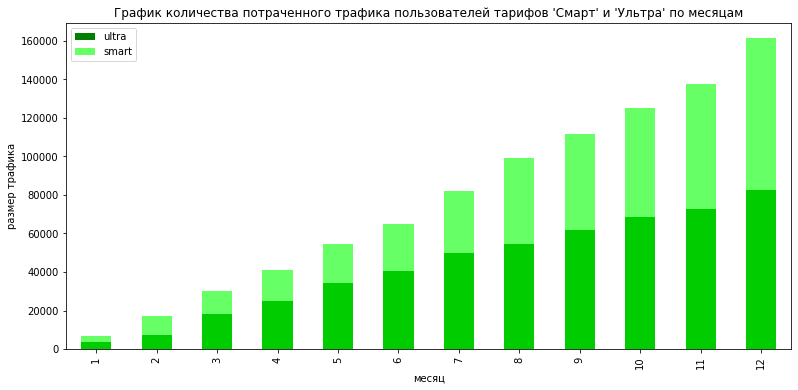

In [25]:
ax = tariff_ultra.plot(y='mb_used',figsize=(13,6), color = 'g',kind='bar',label='ultra')
tariff_smart.plot(y='mb_used',figsize=(13,6), kind='bar',label ='smart', color='lime',alpha=0.6, ax=ax)
ax.set_title("График количества потраченного трафика пользователей тарифов 'Смарт' и 'Ультра' по месяцам")
ax.set_ylabel('размер трафика')
ax.set_xlabel('месяц')

Text(0.5, 0, 'месяц')

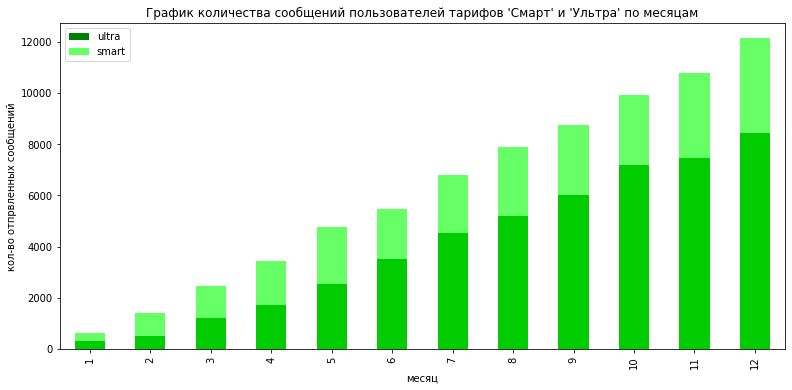

In [26]:
ax = tariff_ultra.plot(y='messages',figsize=(13,6), color = 'g',kind='bar',label='ultra')
tariff_smart.plot(y='messages',figsize=(13,6), kind='bar',label ='smart', color='lime',alpha=0.6, ax=ax)
ax.set_title("График количества сообщений пользователей тарифов 'Смарт' и 'Ультра' по месяцам")
ax.set_ylabel('кол-во отпрвленных сообщений')
ax.set_xlabel('месяц')

Для пользователей тарифа смарт также более активны в использовании минут.

Text(0.5, 0, 'месяц')

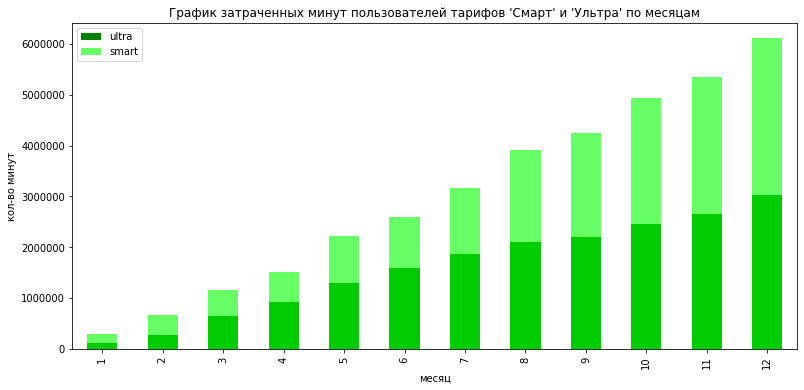

In [27]:
ax = tariff_ultra.plot(y='minutes',figsize=(13,6), color = 'g',kind='bar',label='ultra')
tariff_smart.plot(y='minutes',figsize=(13,6), kind='bar',label ='smart', color='lime',alpha=0.6, ax=ax)
ax.set_title("График затраченных минут пользователей тарифов 'Смарт' и 'Ультра' по месяцам")
ax.set_ylabel('кол-во минут')
ax.set_xlabel('месяц')

In [28]:
data_statistics = final_data.pivot_table(index=['tariff'],values=['minutes', 'messages', 'mb_used'], aggfunc=['mean','median', 'var', 'std'])
data_statistics

mean                           median                   \
             mb_used   messages     minutes   mb_used messages minutes   
tariff                                                                   
smart   16208.386990  33.384029  417.934948  16506.84     28.0   422.0   
ultra   19468.805208  49.363452  526.623350  19308.01     38.0   518.0   

                 var                                       std             \
             mb_used     messages        minutes       mb_used   messages   
tariff                                                                      
smart   3.446250e+07   796.812958   36219.315784   5870.476681  28.227876   
ultra   1.017510e+08  2285.266143  100873.633397  10087.170752  47.804457   

                    
           minutes  
tariff              
smart   190.313730  
ultra   317.606098

Построим гистограммы распределения для каждого параметра тарифа.

In [29]:
ultra_tariff = final_data.query('tariff=="ultra"')
smart_tariff = final_data.query('tariff=="smart"')

Text(0.5, 1.0, "График распределения затраченных минут пользователей 'Ультра'")

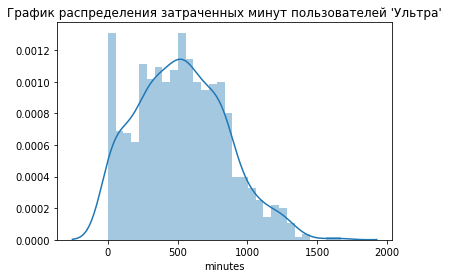

In [30]:
sns.distplot(ultra_tariff['minutes'],bins=30).set_title("График распределения затраченных минут пользователей 'Ультра'")

Text(0.5, 1.0, "График распределения затраченных минут пользователей 'Смарт'")

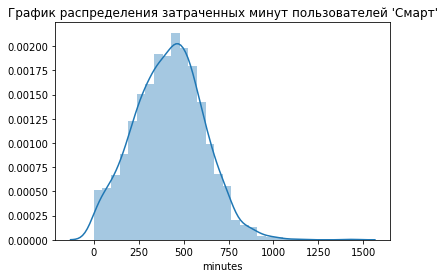

In [31]:
sns.distplot(smart_tariff['minutes'],bins=30).set_title("График распределения затраченных минут пользователей 'Смарт'")

На приведенных гистограммах можно заметить, что пользователи обоих тарифов крайне редк отправляют сообщения.

Text(0.5, 1.0, "График распределения сообщений пользователей 'Ультра'")

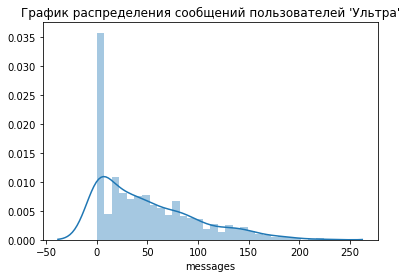

In [32]:
sns.distplot(ultra_tariff['messages'],bins=30).set_title("График распределения сообщений пользователей 'Ультра'")

Text(0.5, 1.0, "График распределения сообщений пользователей 'Смарт'")

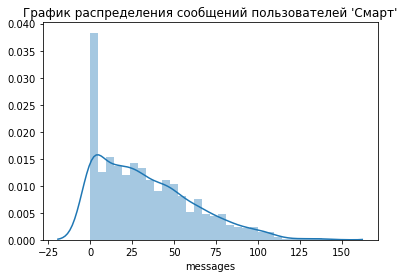

In [33]:
sns.distplot(smart_tariff['messages'],bins=30).set_title("График распределения сообщений пользователей 'Смарт'")

Text(0.5, 1.0, "График распределения трафика пользователей 'Ультра'")

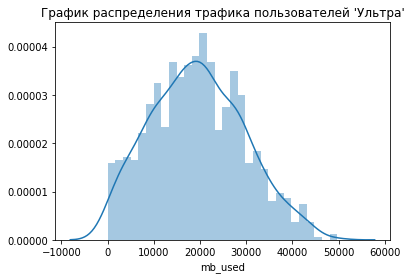

In [34]:
sns.distplot(ultra_tariff['mb_used'],bins=30).set_title("График распределения трафика пользователей 'Ультра'")

Text(0.5, 1.0, "График распределения трафика пользователей 'Смарт'")

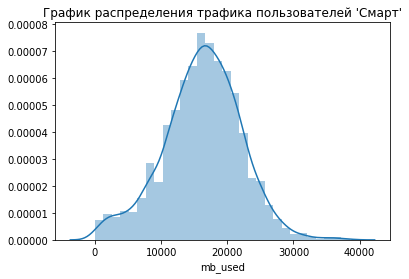

In [35]:
sns.distplot(smart_tariff['mb_used'],bins=30).set_title("График распределения трафика пользователей 'Смарт'")

Также можно заметить, что пользователи тарифа "Ультра" не тратят весь базовый пакет минут и количества сообщения, в отличие от пользователей "Смарт", о чем уже говорилось ранее.

## Проверка статистических гипотез

Заключительным этапом работы будет проверка двух статистических гипотез с помощью метода scipy.stats.ttest_ind(), позволяющем проверить гипотезу о равенстве среднего двух
генеральных совокупностей по взятым из них выборкам:

 1. средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
 2. средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов.
Для проверки гипотез установим уровень значимости равным 0.05.

В первую очередь сформулируем нулевую и альтернативную гипотезу для проверки первого утверждения:
1. гипотеза H₀ будет состоять в том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается;
2. гипотеза H₁ будет сформулирована так: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается. 

In [36]:
alpha = 0.05
ultra = final_data.loc[final_data.loc[:,'tariff'] == 'ultra']['revenue']
smart = final_data.loc[final_data.loc[:, 'tariff'] == 'smart']['revenue']
results = st.ttest_ind(ultra, smart)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.4229814360764067e-160
Отвергаем нулевую гипотезу


Соответственно, можно сделать вывод о том, что средняя выручка пользователей разных тарифов отличается.

Cформулируем нулевую и альтернативную гипотезу для проверки следующего утверждения:
1. гипотеза H₀ будет состоять в том, что средняя выручка пользователи из Москвы не отличается от выручки пользователей из других регионов;
2. гипотеза H₁ будет сформулирована так: средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов. 

In [37]:
revenue_moscow = final_data.loc[final_data.loc[:,'city'] == 'Москва']['revenue']
revenue_other = final_data.loc[final_data.loc[:,'city'] != 'Москва']['revenue']
results = st.ttest_ind(revenue_moscow, revenue_other, equal_var=False) 
prob_city = results.pvalue
print("p-значение:{}".format(prob_city))
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


Можно сделать вывод о том, что географический фактор не влияет на выручку пользователей.

# Общий вывод

Таким образом, по результатам анализа можно сделать вывод о том, что тариф «Ультра» более выгоден, чем тариф «Смарт»: средняя ежемесячная выручка «Мегалайн» от одного пользователя составляет  2040 руб. и 1234  руб., соответственно.

Кроме того, можно сделать следующие выводы:
1. пользователи тарифа "Смарт" не выходят, согласно среднему, из лимита сообщений и минут (у них даже остается небольшая часть тарифа), в то время как трафика им зачастую не хватает. В свою очередь пользователи "Ультра" в среднем не расходуют и половины трафика, сообщений и звонков, а если превышают, то не намного, что говорит о некотором неудобстве тарифа.
2. средние доходы от пользователей в Москве не отличаются от доходов в других населенных пунктах: разница статистически незначима (p-значение: 0,7), в то время как средняя выручка пользователей разных тарифов отличается.